In [1]:
import numpy as np
import scipy.io
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
os.chdir("C:/Users/48786/Desktop/monkey-gaze-following/data/Monkey E")

In [3]:
mat_name = "Emil_LED26_2023-04-18-11-21-51-716.mat"
mat = scipy.io.loadmat(mat_name)
details = pd.read_csv('all_data.csv') 

In [4]:
session = details[details['filename']==mat_name]

### Extract additional information

In [5]:
correct_resp = session[session['got_reward']==1]

valid = session[(session['response_from_tracking'] == 2) | (session['response_from_tracking'] == 6)]
invalid = session[(session['response_from_tracking'] != 2) & (session['response_from_tracking'] != 6)] 
invalid_trials = invalid['trial_id'].tolist()

congruent = session[session['cue_lum_congruency'] == True] 
congruent_trials = congruent['trial_id'].tolist()
incongruent = session[session['cue_lum_congruency'] == False] 
incongruent_trials = incongruent['trial_id'].tolist()

In [6]:
cues_loc = [] # initialise 

for i in mat['StringColumns']:
    avi = i[0][0].split('/')
    if avi[-1] == 'target2.avi':
        cue = 1 # right
    elif avi[-1] == 'target6.avi':
        cue = 2 # left
    cues_loc.append(cue)

In [7]:
right_cue_idx = [i for i, value in enumerate(cues_loc) if value == 1]
left_cue_idx = [j for j, value in enumerate(cues_loc) if value == 2]

In [8]:
## Delete invalid trials

for i in range(1, len(session)):
    if i in invalid_trials:
        if i in right_cue_idx:
            right_cue_idx.remove(i)
        elif i in left_cue_idx:
            left_cue_idx.remove(i)
            
        if i in congruent_trials:
            congruent_trials.remove(i)
        elif i in incongruent_trials:
            incongruent_trials.remove(i)
        
len(left_cue_idx) + len(right_cue_idx) == len(valid)

True

In [9]:
len(congruent_trials) + len(incongruent_trials) == len(valid)

True

In [10]:
num_trials = mat['num_trials'][0][0]
num_samples = len(mat['EyeX'])
sampling_rate = mat['samplingRate'][0][0] # Hz
time_vec = np.arange(num_samples) / sampling_rate 

In [11]:
soa = mat['TrialList'][:, 11] # stimulus onset asynchrony
isi = mat['TrialList'][:, 12]
cue_onset = int((0.1 + 0.5) * sampling_rate) # index
target_onset = (cue_onset + (session['soa']*1000)) 

In [12]:
Xdata = mat['EyeX']
Ydata = mat['EyeY']

### Smoothing the data

Horizontal and vertical position of eyes are smoothed using a window length of 5-ms (10 samples) Savitzky–Golay filter of 2nd degree polynomial. 

In [13]:
Xdata_smoothed = savgol_filter(Xdata, 5, 2)
Ydata_smoothed = savgol_filter(Ydata, 5, 2)

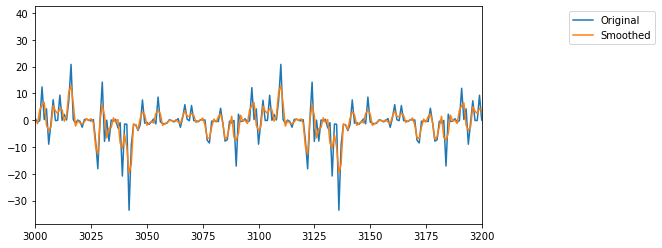

In [14]:
fig = plt.figure(figsize=(8,4))
plt.plot(Xdata.reshape(-1), label = 'Original')
plt.plot(Xdata_smoothed.reshape(-1), label = 'Smoothed')
plt.xlim(left=3000, right=3200) # example chunk of data
plt.legend(bbox_to_anchor=(1.4,1))

### Window of data

All analyses will be done on microsaccades during fixation `1000 samples` before a cue onset until a maximum duration of a target onset within a session. 

In [15]:
# take chunk of data before and after cue onset

around_cue_time = time_vec[(cue_onset-1000):(cue_onset+int(max(target_onset)))]
window_around_cue_X = Xdata_smoothed[(cue_onset-1000):(cue_onset+int(max(target_onset))), :]
window_around_cue_Y = Ydata_smoothed[(cue_onset-1000):(cue_onset+int(max(target_onset))), :]

### Calculate eye velocity

Eye velocity is calculated by differentiating the radial magnitude time series for each trial. 

In [16]:
eye_velocity = []

for i in range(num_trials):
    x = window_around_cue_X[:, i]
    y = window_around_cue_Y[:, i]

    dX = np.gradient(x, around_cue_time)
    dY = np.gradient(y, around_cue_time)

    velocity = np.sqrt((dX**2)+(dY**2))
    
    eye_velocity.append(velocity)

In [17]:
eye_velocity = savgol_filter(eye_velocity, 15, 4)

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

example_trial = np.random.randint(Xdata.shape[1])
x_trace = window_around_cue_X[:, example_trial]
y_trace = window_around_cue_Y[:, example_trial]
example_velocity = eye_velocity[example_trial]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, x_title = 'Time (ms)')

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=x_trace, mode='lines', name='Horizontal Eye Position'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=y_trace, mode='lines', name='Vertical Eye Position'), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=list(range(len(example_velocity))), y=example_velocity, mode='lines'), row=2, col=1)

# Update layout
fig.update_layout(title_text="Example Trial", height=600, title_x = 0.5)

# yaxis_title='Relative Eye Position (°)'
fig.show()


In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming Xdata, window_around_cue_X, window_around_cue_Y, and eye_velocity are defined

example_trial = np.random.randint(Xdata.shape[1])
x_trace = window_around_cue_X[:, example_trial]
y_trace = window_around_cue_Y[:, example_trial]
example_velocity = eye_velocity[example_trial]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, x_title='Time (ms)')

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=x_trace, mode='lines', name='Horizontal Eye Position'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=y_trace, mode='lines', name='Vertical Eye Position'), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=list(range(len(example_velocity))), y=example_velocity, mode='lines', name='Velocity Trace'), row=2, col=1)

# Update layout
fig.update_layout(title_text="Example Trial", height=500, width = 900, title_x=0.5, yaxis=dict(title='Relative Eye Position (°)'), yaxis2=dict(title='Eye Velocity (°/sec)'))
fig.show()


### Microsaccade & saccade detection based on velocity and duration

Algorithm classifies eye movements as `microsaccades` if the absolute velocity at a given time exceedes the threshold of `20 degrees/sec` and it remains like that for at least `2 ms`. These criteria were set based on visual inspections of the data. Classification of `saccades` was based on a velocity criterion that had to exceed `100 degrees/sec`.

In [74]:
## Microsaccades 
dur_th = 3 # ms
amp_th = 1 # degrees
vel_th = 30 # degrees per second

In [75]:
microsaccade_indices = np.zeros((len(window_around_cue_X), num_trials))
candidate_start = None

sacc_amps = []
sacc_velos = []
sacc_dur = []
mcsacc_amps = []
mcsacc_velos = []
mcsacc_dur = []

for trial in range(1, num_trials):
    candidate_start = None

    for i in range(1, len(window_around_cue_X)):
        velocity = abs(eye_velocity[trial][i])

        # Check if velocity is above the threshold
        if velocity > vel_th:
            # Start a new candidate
            if candidate_start is None:
                candidate_start = i
        elif candidate_start is not None:
            candidate_end = i
            candidate_duration = (around_cue_time[candidate_end] - around_cue_time[candidate_start]) * 1000  # in ms

            if candidate_start < candidate_end:
                if candidate_duration >= dur_th:
                    amp_diff = np.abs(window_around_cue_X[candidate_end, trial] - window_around_cue_X[candidate_start, trial])
                    amp_val = np.abs(np.nanmax(window_around_cue_X[candidate_start:candidate_end, trial]))

                    if amp_val <= amp_th and all(amp <= 1.0 for amp in window_around_cue_X[candidate_start:candidate_end, trial]):
                        microsaccade_indices[candidate_start:candidate_end, trial] = 1
                        mcsacc_amps.append(amp_val)
                        mcsacc_velos.append(np.nanmax(eye_velocity[trial][candidate_start:candidate_end]))
                        mcsacc_dur.append(candidate_duration)
                    elif amp_val > 1.0 or any(amp > 1.0 for amp in window_around_cue_X[candidate_start:candidate_end, trial]):
                        sacc_amps.append(amp_val)
                        sacc_velos.append(np.nanmax(eye_velocity[trial][candidate_start:candidate_end]))
                        sacc_dur.append(candidate_duration)
                        microsaccade_indices[candidate_start:candidate_end, trial] = 2

                    candidate_start = None
                else:
                    candidate_start = None

    # If microsaccade is at the end of the trial
    if candidate_start is not None and candidate_start < len(eye_velocity[trial]) - 1:
        candidate_end = len(eye_velocity[trial]) - 1
        candidate_duration = (around_cue_time[candidate_start] - around_cue_time[candidate_end]) * 1000  # convert to ms

        if candidate_duration >= dur_th:
            amp_val = np.abs(np.nanmax(window_around_cue_X[candidate_start:candidate_end, trial]))

            if amp_val <= amp_th and all(amp <= 1.0 for amp in window_around_cue_X[candidate_start:candidate_end, trial]):
                mcsacc_amps.append(amp_val)
                mcsacc_velos.append(np.nanmax(eye_velocity[trial][candidate_start:candidate_end]))
                microsaccade_indices[candidate_start:candidate_end, trial] = 1
                mcsacc_dur.append(candidate_duration)
            elif amp_val > 1.0 or any(amp > 1.0 for amp in window_around_cue_X[candidate_start:candidate_end, trial]):
                sacc_amps.append(amp_val)
                sacc_velos.append(np.nanmax(eye_velocity[trial][candidate_start:candidate_end]))
                sacc_dur.append(candidate_duration)
                microsaccade_indices[candidate_start:candidate_end, trial] = 2


        candidate_start = None


In [79]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

example_trial = np.random.randint(Xdata.shape[1])
print(example_trial)
x_trace = window_around_cue_X[:, example_trial]
#y_trace = window_around_cue_Y[:, example_trial]
example_velocity = eye_velocity[example_trial]

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add traces for the first subplot
fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=x_trace, mode='lines', name='Horizonal Eye Position'), row=1, col=1)
#fig.add_trace(go.Scatter(x=list(range(len(x_trace))), y=y_trace, mode='lines', name='Vertical eye position'), row=1, col=1)

# Add traces for the second subplot
fig.add_trace(go.Scatter(x=list(range(len(example_velocity))), y=example_velocity, mode='lines', name='Velocity'), row=2, col=1)

# Add traces for the third plot
fig.add_trace(go.Scatter(x=list(range(len(microsaccade_indices[:, example_trial]))), y=microsaccade_indices[:, example_trial], mode='lines', name='Algorithm Results'), row=3, col=1)

# Update layout
#fig.update_layout(title_text="Microsaccades detection", height=600, width=800)
fig.update_layout(title_text="Mirosaccades Detection", height=700, width = 1000, title_x=0.5, yaxis=dict(title='Relative Eye Position (°)'), yaxis2=dict(title='Eye Velocity (°/sec)'), yaxis3=dict(title='Algorithm Prediction'))

# Update y-axis ticks and tick text for the third subplot
fig.update_yaxes(tickvals=[1, 2], ticktext=["mcsacc", "sacc"], row=3, col=1)

fig.show()


69


In [102]:
### problematic trial 43 and 93 is off

## possible 20,88

### Characterize samples with detected microsaccades

In [179]:
mcsacc_amps = np.abs(mcsacc_amps)
sacc_amps = np.abs(sacc_amps)

In [189]:
np.min(mcsacc_amps)

0.00026372394565057217

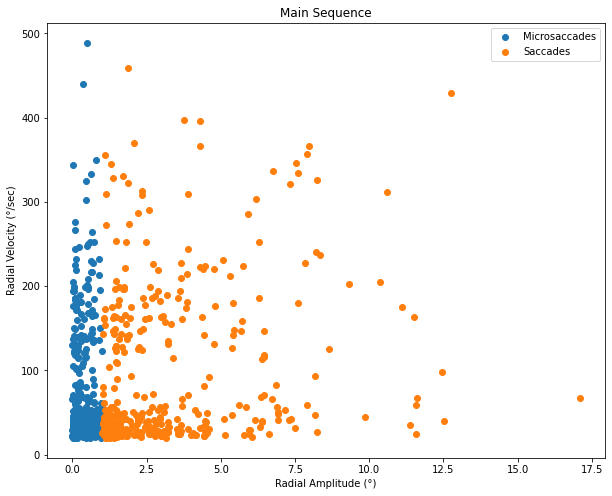

In [192]:
plt.figure(figsize=(10, 8))
plt.scatter(mcsacc_amps, mcsacc_velos, label="Microsaccades")
plt.scatter(sacc_amps, sacc_velos, label="Saccades")
plt.title("Main Sequence")
plt.ylabel("Radial Velocity (°/sec)")
plt.xlabel("Radial Amplitude (°)")
#plt.ylim([3,6])
plt.legend()
plt.show()

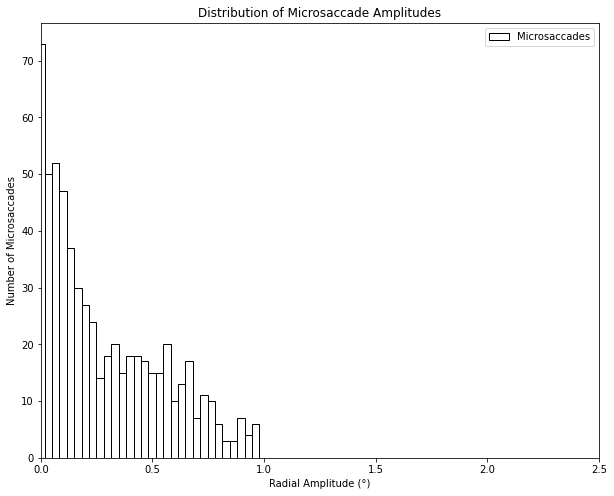

In [205]:
plt.figure(figsize=(10,8))
plt.hist(mcsacc_amps, bins=30, align='left', label = 'Microsaccades', fill=False)
#plt.hist(sacc_amps, bins=20, align='left', label = 'Saccades')
plt.title("Distribution of Microsaccade Amplitudes")
plt.xlabel('Radial Amplitude (°)')
plt.ylabel('Number of Microsaccades')
plt.xlim([0.0, 2.5])
plt.legend(loc='upper right')
plt.show()

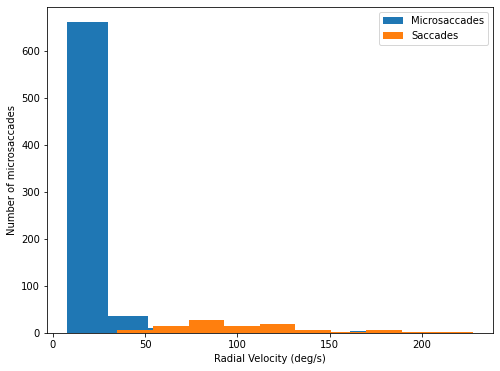

In [363]:
plt.figure(figsize=(8,6))
plt.hist(mcsacc_velos, align='left', label='Microsaccades')
plt.hist(sacc_velos, align='left', label = 'Saccades')
plt.xlabel('Radial Velocity (deg/s)')
plt.ylabel('Number of microsaccades')
plt.legend(loc='upper right')
plt.show()

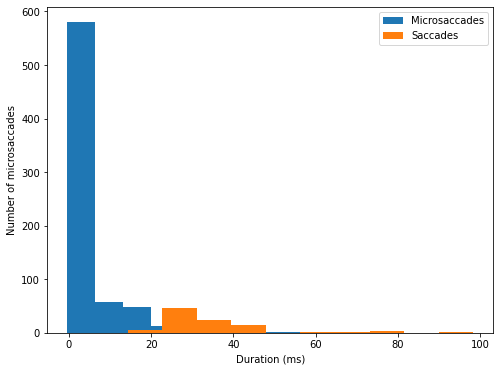

In [364]:
plt.figure(figsize=(8,6))
plt.hist(mcsacc_dur, align='left', label = 'Microsaccades')
plt.hist(sacc_dur, align='left', label = 'Saccades')
plt.xlabel('Duration (ms)')
plt.legend(loc='upper right')
plt.ylabel('Number of microsaccades')
plt.show()

### Identification by Dispersion-Threshold (IDT) algorithm

In [45]:
## Set the parameters

fix_duration_threshold_sec = 0.05
fix_dispersion_threshold = 55 #arbitrary number
saccade_velocity_threshold = 0.5 
saccade_duration_threshold = 0.005

In [46]:
xy_o = [window_around_cue_X, window_around_cue_Y] # list of two NumPy arrays representing eye positions in X and Y direction

xy = [np.copy(arr) for arr in xy_o]
#xy = [np.delete(arr, np.where(arr==np.nan)) for arr in xy] # Remove NaNs

xy_ = [np.copy(arr) for arr in xy] # To be returned with blinks interpolated
xy_idxs = [np.arange(len(arr)) for arr in xy] # 2D array with corresponding indices 

In [47]:
fix_window_length = int(fix_duration_threshold_sec * sampling_rate)
sac_idx = []
fix_idx = []
blink_idx = []

In [127]:
while any(xy_idxs[0]):
    if len(xy_idxs[0]) > fix_window_length: # lower duration threshold for saccades
        current_window_idxs = np.arange(fix_window_length)
    else:
        #print(len(xy_idxs[0]))
        current_window_idxs = np.arange(len(xy_idxs[0]))

    #print('Current window idxs before appending', current_window_idxs, '\n')

    current_window_vals = [arr[current_window_idxs] for arr in xy]
    # window dispersion
    wd = (np.max(current_window_vals[0]) - np.min(current_window_vals[0])
            + np.max(current_window_vals[1]) - np.min(current_window_vals[1])
         )
    #print('Window dispersion', wd)
    ## If dispersion in current window is smaller than threshold
    if wd <= fix_dispersion_threshold:
        #print('Window dispersion', wd, '-- smaller than threshold.')
        if wd <= fix_dispersion_threshold and len(current_window_idxs) < len(xy_idxs[0]):
            ## Append to indices of current window
            current_window_idxs = np.append(current_window_idxs, np.max(current_window_idxs) + 1)
            ## Append to values of current window
            current_window_vals[0] = xy[0][current_window_idxs]
            current_window_vals[1] = xy[1][current_window_idxs]

            wd = (np.max(current_window_vals[0]) - np.min(current_window_vals[0])
                    + np.max(current_window_vals[1]) - np.min(current_window_vals[1])
                 )

        ## Add fixation to array 
        #print('Current window of fixations', xy_idxs[0][current_window_idxs])
        fix_idx.append(xy_idxs[0][current_window_idxs])
        ## Delete window from data 
        
        xy = [np.delete(arr, current_window_idxs) for arr in xy]
        xy_idxs = [np.delete(arr, current_window_idxs) for arr in xy_idxs]
        #print('Length after removal of the entire window', len(xy_idxs[0]), '\n')
        
        
    else: ## If dispersion in current window is greater than threshold delete first data point
        #print('Above the threshold')
        xy = [np.delete(arr, 0) for arr in xy]
        xy_idxs = [np.delete(arr, 0) for arr in xy_idxs]
        if len((xy_idxs[0])) == 1:
            break
        #print('Length', len(xy_idxs[0]))



In [128]:
fix_idx

[array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 1

In [129]:
for idx in range(len(fix_idx) - 1):
    if fix_idx[idx + 1][0] - fix_idx[idx][-1] > saccade_velocity_threshold:
        print()
        sac_idx.append(np.arange(fix_idx[idx][-1], fix_idx[idx+1][0]))
    
saccade_velocities = [np.diff(xy_[0][sac]) for sac in sac_idx]

In [133]:
sac_idx

[array([101]),
 array([202]),
 array([303]),
 array([404]),
 array([505]),
 array([606]),
 array([707]),
 array([808]),
 array([909]),
 array([1010]),
 array([1111]),
 array([1212]),
 array([1313]),
 array([1414]),
 array([1515]),
 array([1616]),
 array([1717]),
 array([1818]),
 array([1919]),
 array([2020]),
 array([2121]),
 array([2222])]

### Detect microsaccade bias depending on cue direction

In [216]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [217]:
right_eye_velocities = []
for i in right_cue_idx:
    right_eye_velocities.append(eye_velocity[i])

In [218]:
window_around_cue_X[:, 0].shape

(2300,)

In [219]:
right_X = window_around_cue_X[:, right_cue_idx]
right_mcc = (microsaccade_indices[:, right_cue_idx] == 1)
right_mcc_amplitudes = []
right_mcc_velocities = []

In [220]:
ex = right_X[:, 1]
mcex = right_mcc[:,1]
ex[mcex]

array([ 0.11514252,  0.11280446,  0.09835947,  0.08424844,  0.06732457,
        0.0694935 , -0.01267775, -0.01863153, -0.04240829, -0.0523208 ,
       -0.06954313, -0.06644689, -0.04765271, -0.04052028, -0.02795799,
       -0.02344078, -0.00882276,  0.00275337,  0.00733578,  0.00264528,
       -0.00793631, -0.00044608, -0.01418837, -0.03128448, -0.05191953,
       -0.06505515, -0.07176501, -0.04190719, -0.04730984, -0.05068084,
       -0.04615827, -0.03252443, -0.02307098])

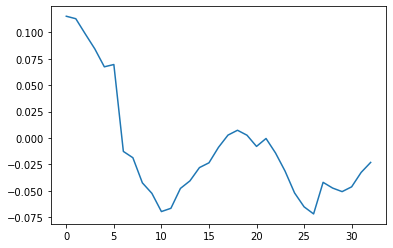

In [221]:
plt.plot(ex[mcex])

C:\Users\Student\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Student\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



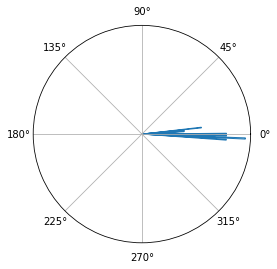

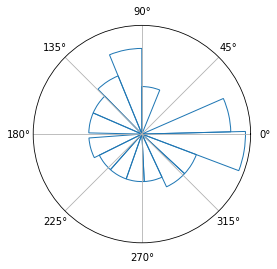

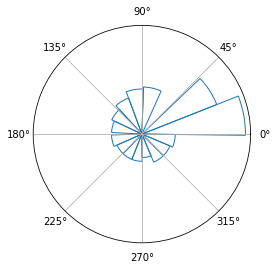

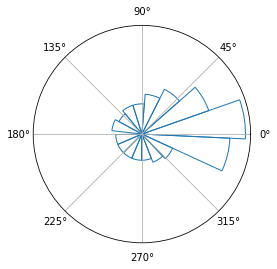

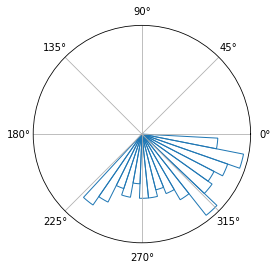

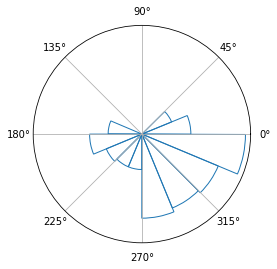

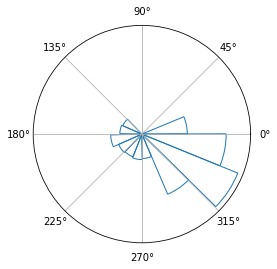

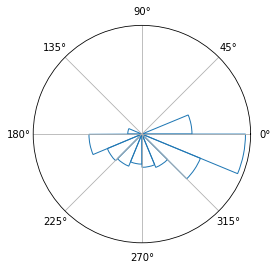

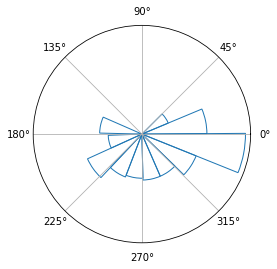

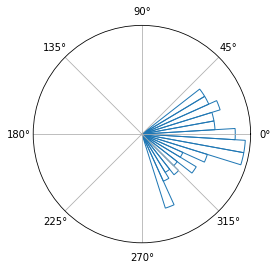

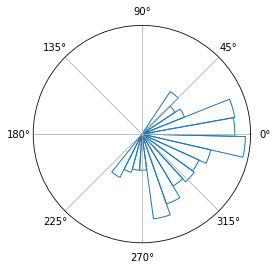

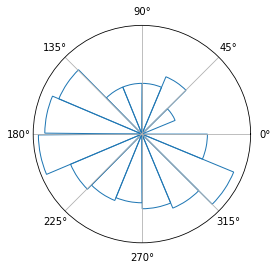

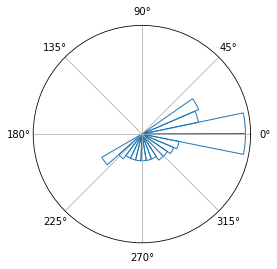

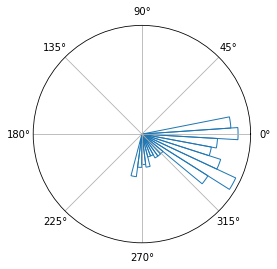

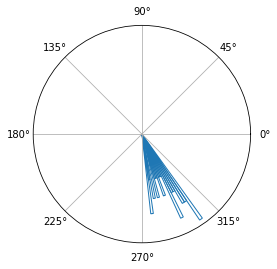

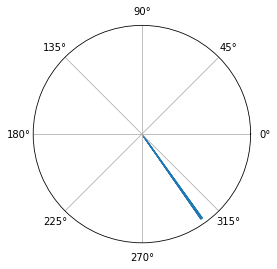

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 432x288 with 1 Axes>

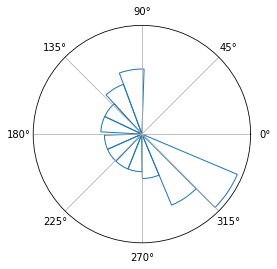

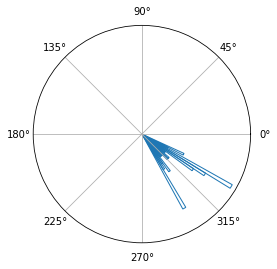

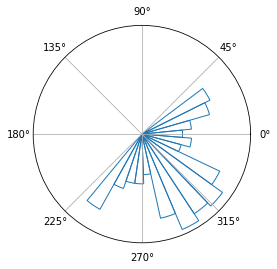

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 432x288 with 1 Axes>

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 432x288 with 1 Axes>

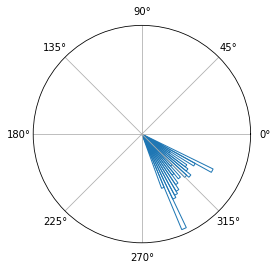

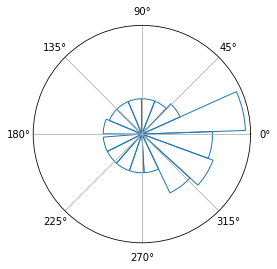

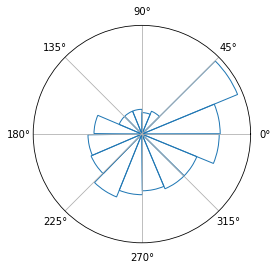

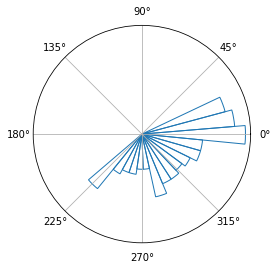

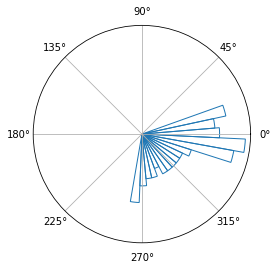

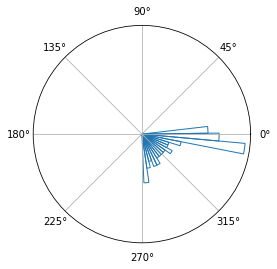

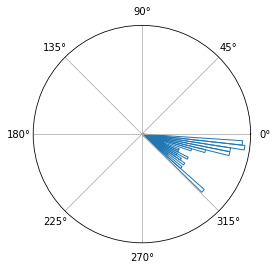

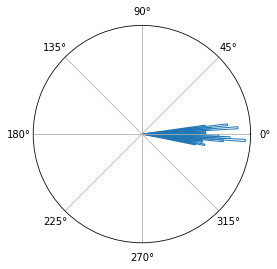

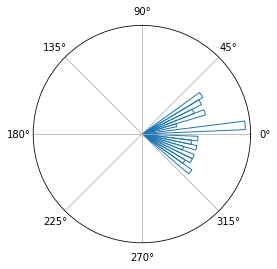

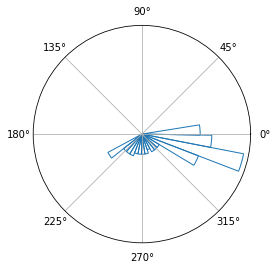

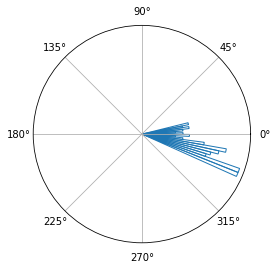

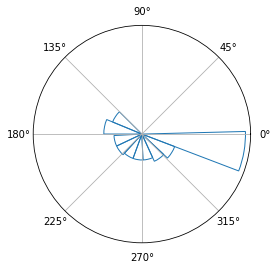

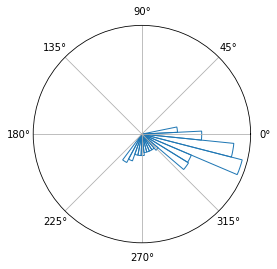

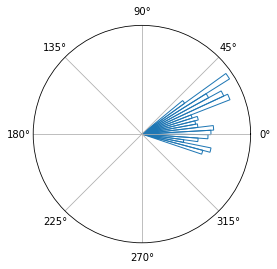

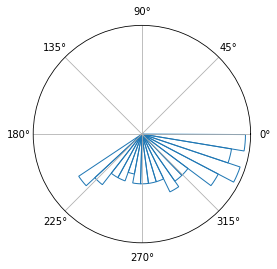

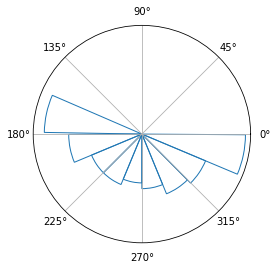

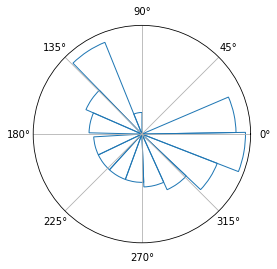

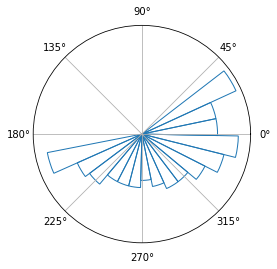

Error in callback <function flush_figures at 0x0000023A3D4D86A8> (for post_execute):


KeyboardInterrupt: 

In [224]:
for trial in range(1, right_X.shape[1]):
    right_trial_X = right_X[:, trial] # Eye X values for trial
    right_trial_velo = right_eye_velocities[trial]
    right_trial_mcc = right_mcc[:, trial] # microsaccade detections for trial 
    right_mcc_amplitudes.append(right_trial_X[right_trial_mcc])
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    circular_hist(ax, right_trial_X[right_trial_mcc])
    right_mcc_velocities.append(right_trial_velo[right_trial_mcc])

In [226]:
right_X

array([[ 2.43427807,  2.85234589,  3.85334594, ...,  0.16943975,
         0.6869585 ,  0.63605297],
       [ 2.43615459,  2.86120794,  3.85348449, ...,  0.17835797,
         0.68629507,  0.64370845],
       [ 2.44700586,  2.86781257,  3.84632772, ...,  0.17492103,
         0.68546912,  0.64123577],
       ...,
       [ 7.56899925,  8.1024348 , -6.87964943, ..., -4.63545267,
        -5.71493695, -2.78032073],
       [ 7.56238678,  8.09677048, -6.87972469, ..., -4.648348  ,
        -5.64979072, -2.68778847],
       [ 7.57003697,  8.10092794, -6.87821819, ..., -4.66577269,
        -5.59356042, -2.60805647]])

In [227]:
circular_hist(ax, right_X)

C:\Users\Student\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in remainder



ValueError: autodetected range of [nan, nan] is not finite

In [223]:
plt.plot(right_trial_X[right_trial_mcc])

NameError: name 'right_trial_X' is not defined

In [66]:
right_mcc[:, 1]

array([False, False, False, ..., False, False, False])

Text(0.5, 0, 'Timebins')

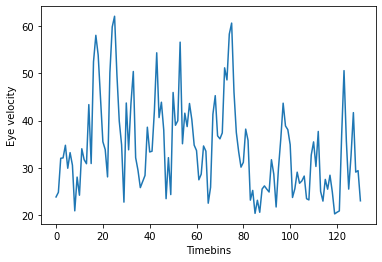

In [27]:
plt.plot(right_mcc_velocities[41])
plt.ylabel('Eye velocity')
plt.xlabel('Timebins')

In [35]:
left_eye_velocities = []
for i in left_cue_idx:
    left_eye_velocities.append(eye_velocity[i])

left_X = window_around_cue_X[:, left_cue_idx]
left_mcc = (microsaccade_indices[:, left_cue_idx] == 1)
left_mcc_amplitudes = []
left_mcc_velocities = []

In [43]:
left_X[:, 0].shape

(2000,)

C:\Users\Student\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


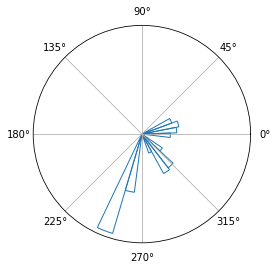

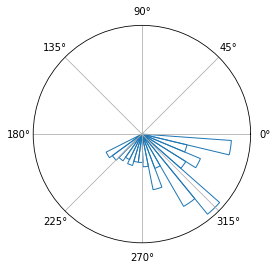

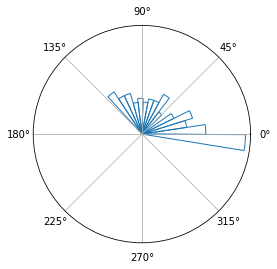

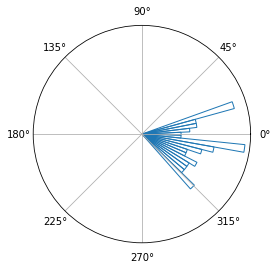

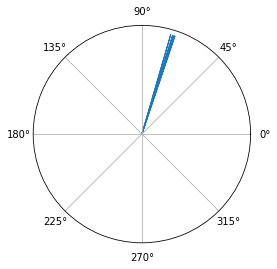

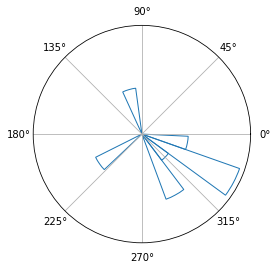

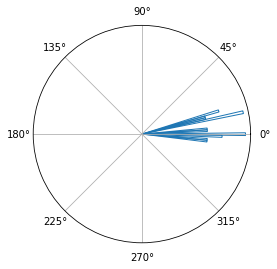

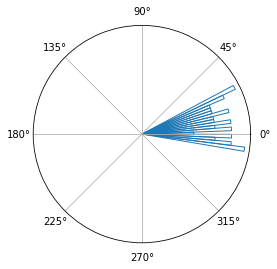

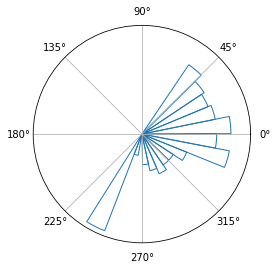

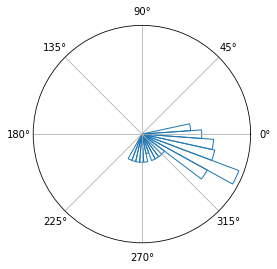

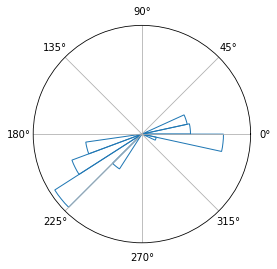

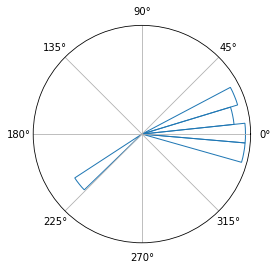

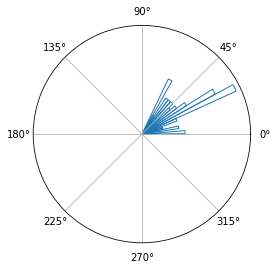

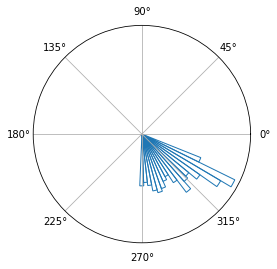

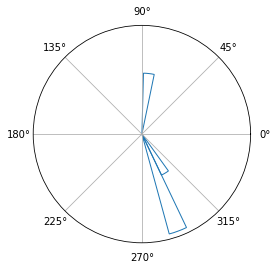

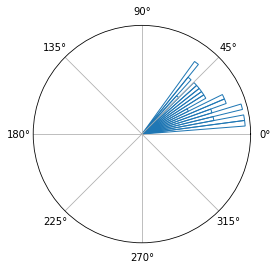

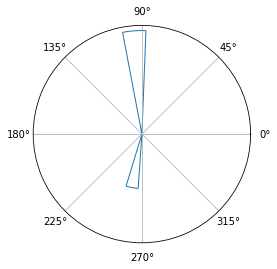

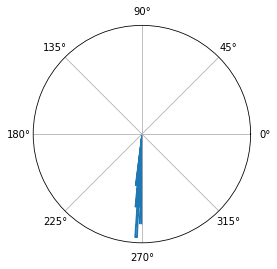

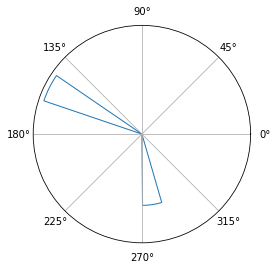

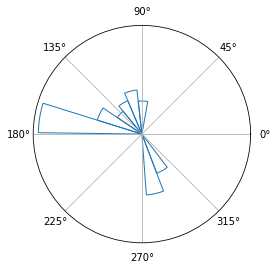

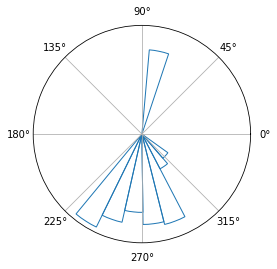

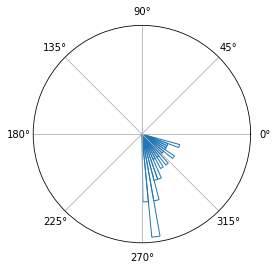

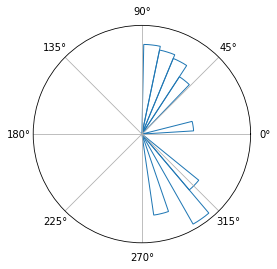

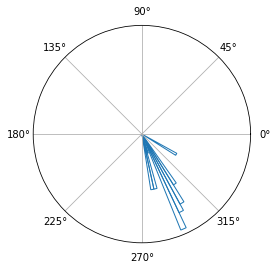

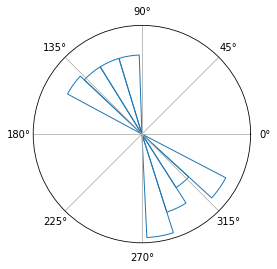

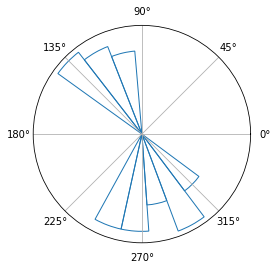

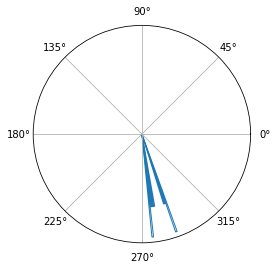

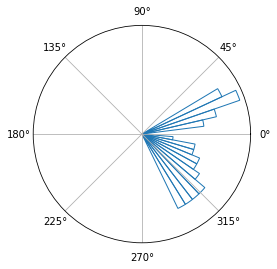

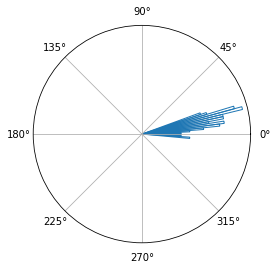

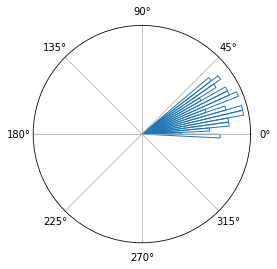

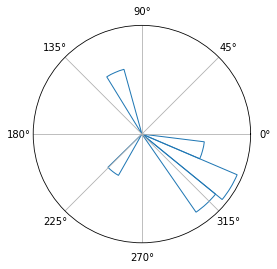

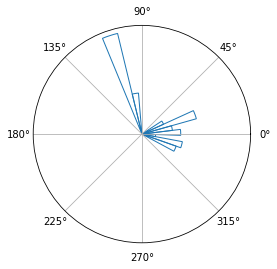

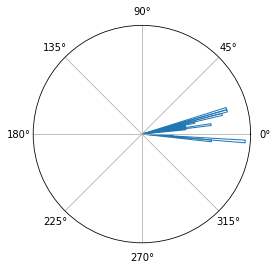

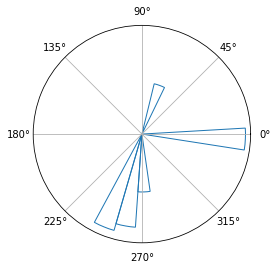

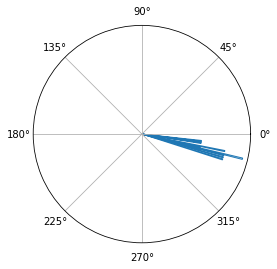

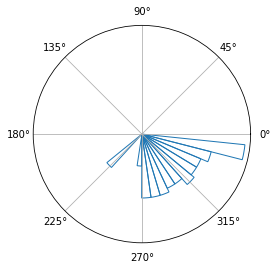

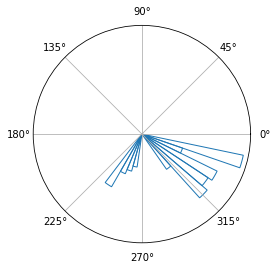

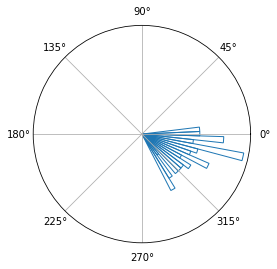

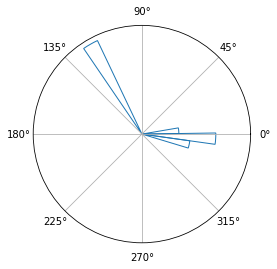

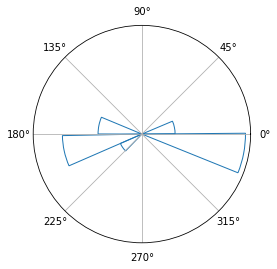

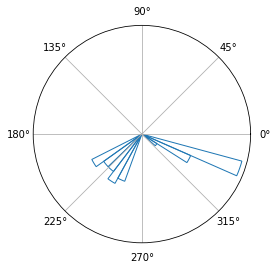

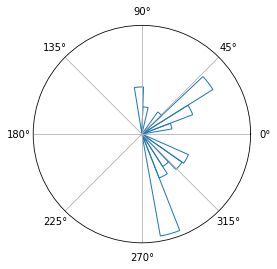

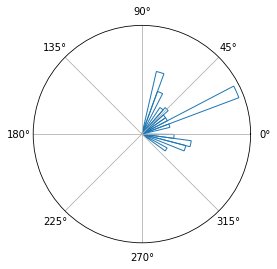

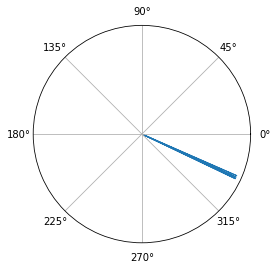

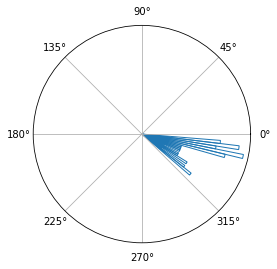

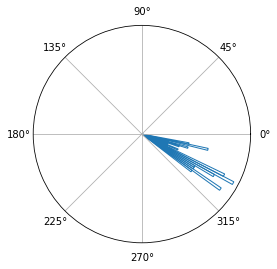

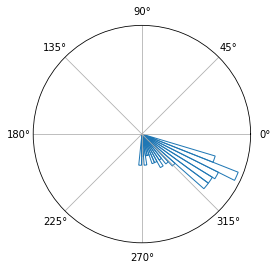

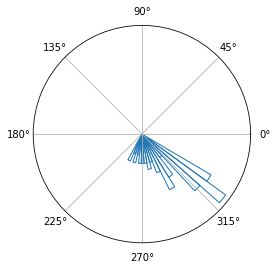

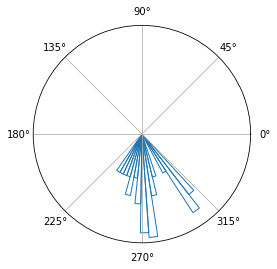

In [45]:
for trial in range(1, left_X.shape[1]):
    left_trial_X = left_X[:, trial] # Eye X values for trial
    left_trial_velo = left_eye_velocities[trial]
    left_trial_mcc = left_mcc[:, trial] # microsaccade detections for trial 
    left_mcc_amplitudes.append(left_trial_X[left_trial_mcc])
    if left_trial_X[left_trial_mcc].shape[0] > 0:
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        circular_hist(ax, left_trial_X[left_trial_mcc])
    else:
        continue
    left_mcc_velocities.append(left_trial_velo[left_trial_mcc])

(array([13, 12, 12,  4,  5,  4,  9,  5, 10,  9,  9, 10,  2, 10, 11,  6],
       dtype=int64),
 array([-0.65936796, -0.57833174, -0.49729552, -0.4162593 , -0.33522308,
        -0.25418686, -0.17315064, -0.09211441, -0.01107819,  0.06995803,
         0.15099425,  0.23203047,  0.31306669,  0.39410291,  0.47513913,
         0.55617536,  0.63721158]),
 <BarContainer object of 16 artists>)

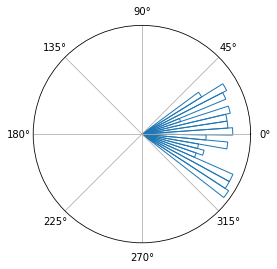

In [26]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
circular_hist(ax, right_mcc_amplitudes[41])